In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

ModuleNotFoundError: No module named 'google.colab'

In [2]:
import glob
import urllib.request
import imageio
import os
import time
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from urllib.request import urlopen

import tensorflow as tf
from tensorflow.keras.layers import Concatenate, Dropout, Reshape, Input, Dense
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import initializers
from sklearn.metrics import mean_squared_error

In [2]:
print("Loading Glove Model")
gloveFile = open("/content/drive/MyDrive/text2Image/glove.6B.300d.txt",'r',encoding="utf8")
glove_embeddings = {}
for line in gloveFile:
    try:
        splitLine = line.split()
        word = splitLine[0]
        enclosing = np.array([float(val) for val in splitLine[1:]])
        glove_embeddings[word] = enclosing
    except:
        print(word)
print("Done-->",len(glove_embeddings),"words loaded!")

Loading Glove Model


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/text2Image/glove.6B.300d.txt'

In [4]:
training_data_path = "/content/drive/MyDrive/text2Image/flowers"
training_images_path = "/content/drive/MyDrive/text2Image/flowers/images/jpg"
training_captions_path = "/content/drive/MyDrive/text2Image/flowers/text_c10"
model_path = "/content/drive/MyDrive/Image2text/flowers/model"
data_path = "/content/drive/MyDrive/text2Image/flowers/images/jpg"
npy64_path = "/content/drive/MyDrive/text2Image/flowers/images/npy64"
text_path = "/content/drive/MyDrive/text2Image/flowers/text_c10"

In [5]:
def hms_string(elapsed):
    hrs = int(elapsed / (60 * 60))
    mins = int((elapsed % (60 * 60)) / 60)
    secs = elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(hrs, mins, secs)

In [6]:
GENERATE_RES = 2
IMAGE_CHANNELS = 3
ROWS_PREVIEW = 4
COLUMNS_PREVIEW = 7
VIEW_MARGIN = 16
SIZE_OF_SEED = 100
EMBEDDING_SIZE = 300
EPOCHS = 50
BATCH_SIZE = 64
BUFFER_SIZE = 4000
GENERATE_SQUARE = 32 * GENERATE_RES

In [7]:
training_binary_path = os.path.join(npy64_path, f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}_')
print("Loading training images...")
training_of_data = []
flowers_path = sorted(os.listdir(data_path))

for file in range(len(flowers_path)):
    path = os.path.join(data_path,flowers_path[file])
    try:
      image = Image.open(path).resize((GENERATE_SQUARE, GENERATE_SQUARE),Image.ANTIALIAS)
      channel = np.asarray(image).shape[2]
      if channel == 3:
        training_of_data.append(np.asarray(image))
    except KeyboardInterrupt:
        print("Keyboard Interrup by me...")
        break
    except:
      pass
    if len(training_of_data) == 100:
      training_of_data = np.reshape(training_of_data,(-1,GENERATE_SQUARE, GENERATE_SQUARE,IMAGE_CHANNELS))
      training_of_data = training_data.astype(np.float32)
      training_of_data = training_of_data / 127.5 -1.
      print("Saving training image " + str(100000 + file) + ".npy")
      np.save(training_binary_path + str(100000 + file) + ".npy",training_of_data)
      training_of_data = []
print("Complete")

Loading training images...
Saving training image 100099.npy
Saving training image 100199.npy
Saving training image 100299.npy
Saving training image 100399.npy
Saving training image 100499.npy
Saving training image 100599.npy
Saving training image 100699.npy
Saving training image 100799.npy
Saving training image 100899.npy
Saving training image 100999.npy
Saving training image 101099.npy
Saving training image 101199.npy
Saving training image 101299.npy
Saving training image 101399.npy
Saving training image 101499.npy
Saving training image 101599.npy
Saving training image 101699.npy
Saving training image 101799.npy
Saving training image 101899.npy
Saving training image 101999.npy
Saving training image 102099.npy
Saving training image 102199.npy
Saving training image 102299.npy
Saving training image 102399.npy
Saving training image 102499.npy
Saving training image 102599.npy
Saving training image 102699.npy
Saving training image 102799.npy
Saving training image 102899.npy
Saving training 

In [8]:
captions = []
count_folder = 0
for folder in os.listdir(text_path):
  if folder[-3:] == '.t7' or folder[-4:] == '.csv':
    continue
  for file in os.listdir(text_path + '/' + folder):
    if file[-4:] == '.txt':
      count_folder += 1

caption_embeddings = np.zeros((count_folder,300),dtype=np.float32)
for folder in os.listdir(text_path):
  if folder[-3:] == '.t7' or folder[-4:] == '.csv':
    continue
  text_files = sorted(os.listdir(text_path + '/' + folder))
  text_file_path = text_path + '/' + folder
  for filename in range(len(text_files)):
      if text_files[filename][-4:] != '.txt':
        continue
      path = os.path.join(text_file_path,text_files[filename])
      f = open(path,'r')
      data = f.read() 
      data = data.split("\n")
      f.close()
      x = data[0].lower().replace(" ","")
      captions.append(x)
      count = 0
      for t in x:
        try:
          caption_embeddings[filename] += glove_embeddings[t]
          count += 1
        except:
          print(t)
          pass
        caption_embeddings[filename] /= count
      if filename %100 == 0:
        print("-------------Files completed:",filename)

In [9]:
embedding_binary_path = os.path.join('/content/drive/MyDrive/text2Image/flowers/images/embedding_npy', f'embedding_data.npy')
print("Saving captions embeddings binary...")
np.save(embedding_binary_path,caption_embeddings)

Saving captions embeddings binary...


In [10]:
df_captions = pd.DataFrame([])
df_captions['captions'] = captions

In [11]:
df_captions.to_csv("/content/drive/MyDrive/text2Image/flowers/text_c10/captions.csv",index=None)

In [12]:
caption_embeddings = np.load(embedding_binary_path)

In [13]:
caption_embeddings.shape

(8189, 300)

In [14]:
image_binary_path = "/content/drive/MyDrive/text2Image/flowers/images/npy64/"
images = os.listdir(image_binary_path)

In [15]:
final_images = np.load(image_binary_path + images[0])
for i in images[1:]:
  print(i)
  try:
    final_images = np.concatenate([final_images,np.load(image_binary_path + i)],axis = 0)
  except:
    pass

training_data_64_64_100399.npy
training_data_64_64_100099.npy
training_data_64_64_100299.npy
training_data_64_64_100499.npy
training_data_64_64_100599.npy
training_data_64_64_100699.npy
training_data_64_64_100799.npy
training_data_64_64_100899.npy
training_data_64_64_101099.npy
training_data_64_64_100999.npy
training_data_64_64_101199.npy
training_data_64_64_101299.npy
training_data_64_64_101399.npy
training_data_64_64_101499.npy
training_data_64_64_101599.npy
training_data_64_64_101899.npy
training_data_64_64_101699.npy
training_data_64_64_101799.npy
training_data_64_64_101999.npy
training_data_64_64_102099.npy
training_data_64_64_102199.npy
training_data_64_64_102299.npy
training_data_64_64_102499.npy
training_data_64_64_102399.npy
training_data_64_64_102599.npy
training_data_64_64_102699.npy
training_data_64_64_102799.npy
training_data_64_64_102999.npy
training_data_64_64_102899.npy
training_data_64_64_103099.npy
training_data_64_64_103199.npy
training_data_64_64_103299.npy
training

In [16]:
final_images.shape

(8100, 64, 64, 3)

In [17]:
df_captions = pd.read_csv("/content/drive/MyDrive/text2Image/flowers/text_c10/captions.csv")

In [18]:
df_captions.head()

,captions
0,"thisflowerisorangeincolor,withpetalsthatarebel..."
1,"ared,heart-shapedpetalswithadeeporangereceptacle"
2,"thisflowerisredincolor,withpetalsthatarehornsh..."
3,afunnel-likeredpedaledflowerwiththepedalscurving.
4,thepedalsofthisflowerareredwithashortstigma


In [19]:
captions = list(df_captions.captions[::5])

In [20]:
len(captions)

1638

In [21]:
save_images_captions = captions[:28].copy()
save_images_embeddings = np.copy(caption_embeddings[:28])
save_images_npy = np.copy(final_images[:28])

In [22]:
caption_embeddings = caption_embeddings[:final_images.shape[0]]

In [23]:
caption_embeddings.shape

(8100, 300)

In [24]:
p = np.random.permutation(len(final_images))
final_images_shuffled = final_images[p]
final_embeddings_shuffled = caption_embeddings[p]

In [25]:
train_dataset = tf.data.Dataset.from_tensor_slices({'images': final_images,
                                                    'embeddings': caption_embeddings}).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [26]:
def build_generator_func(SIZE_OF_SEED,embedding_size, channels):
  input_seed = Input(shape=SIZE_OF_SEED)
  input_embed = Input(shape = embedding_size)
  d0 = Dense(128)(input_embed)
  leaky0 = LeakyReLU(alpha=0.2)(d0)

  merge = Concatenate()([input_seed, leaky0])

  d1 = Dense(4*4*256,activation="relu")(merge)
  reshape = Reshape((4,4,256))(d1)

  upSamp1 = UpSampling2D()(reshape)
  conv2d1 = Conv2DTranspose(256,kernel_size=5,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp1)
  batchNorm1 = BatchNormalization(momentum=0.8)(conv2d1)
  leaky1 = LeakyReLU(alpha=0.2)(batchNorm1)

  upSamp2 = UpSampling2D()(leaky1)
  conv2d2 = Conv2DTranspose(256,kernel_size=5,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp2)
  batchNorm2 = BatchNormalization(momentum=0.8)(conv2d2)
  leaky2 = LeakyReLU(alpha=0.2)(batchNorm2)

  upSamp3 = UpSampling2D()(leaky2)
  conv2d3 = Conv2DTranspose(128,kernel_size=4,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp3)
  batchNorm3 = BatchNormalization(momentum=0.8)(conv2d3)
  leaky3 = LeakyReLU(alpha=0.2)(batchNorm3)

  upSamp4 = UpSampling2D(size=(GENERATE_RES,GENERATE_RES))(leaky3)
  conv2d4 = Conv2DTranspose(128,kernel_size=4,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp4)
  batchNorm4 = BatchNormalization(momentum=0.8)(conv2d4)
  leaky4 = LeakyReLU(alpha=0.2)(batchNorm4)

  outputConv = Conv2DTranspose(channels,kernel_size=3,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(leaky4)
  outputActi = Activation("tanh")(outputConv)

  model = Model(inputs=[input_seed,input_embed], outputs=outputActi)
  return model

def build_discriminator_func(image_shape, embedding_size):
  input_shape = Input(shape=image_shape)
  input_embed = Input(shape=embedding_size)

  conv2d1 = Conv2D(32,kernel_size=4,strides=2,input_shape=image_shape,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(input_shape)
  leaky1 = LeakyReLU(alpha=0.2)(conv2d1)

  drop2 = Dropout(0.25)(leaky1)
  conv2d2 = Conv2D(64, kernel_size=4, strides=2, padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop2)
  # zero2 = ZeroPadding2D(padding=((0,1),(0,1)))(conv2d2)
  batchNorm2 = BatchNormalization(momentum=0.8)(conv2d2)
  leaky2 = LeakyReLU(alpha=0.2)(batchNorm2)

  drop3 = Dropout(0.25)(leaky2)
  conv2d3 = Conv2D(128, kernel_size=4, strides=2, padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop3)
  batchNorm3 = BatchNormalization(momentum=0.8)(conv2d3)
  leaky3 = LeakyReLU(alpha=0.2)(batchNorm3)

  drop4 = Dropout(0.25)(leaky3)
  conv2d4 = Conv2D(256, kernel_size=4, strides=2, padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop4)
  batchNorm4 = BatchNormalization(momentum=0.8)(conv2d4)
  leaky4 = LeakyReLU(alpha=0.2)(batchNorm4)

  dense_embed = Dense(128,kernel_initializer=initializers.RandomNormal(stddev=0.02))(input_embed)
  leaky_embed = LeakyReLU(alpha=0.2)(dense_embed)
  reshape_embed = Reshape((4,4,8))(leaky_embed)
  merge_embed = Concatenate()([leaky4, reshape_embed])

  drop5 = Dropout(0.25)(merge_embed)
  conv2d5 = Conv2D(512, kernel_size=4,kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop5)
  batchNorm5 = BatchNormalization(momentum=0.8)(conv2d5)
  leaky5 = LeakyReLU(alpha=0.2)(batchNorm5)

  drop6 = Dropout(0.25)(leaky5)
  flatten = Flatten()(drop6)
  output = Dense(1,activation="sigmoid")(flatten)

  model = Model(inputs=[input_shape,input_embed], outputs=output)
  return model

In [27]:
generator = build_generator_func(SIZE_OF_SEED,EMBEDDING_SIZE, IMAGE_CHANNELS)


In [28]:
def save_images(cnt,noise,embeds):
  image_array = np.full(( 
      VIEW_MARGIN + (ROWS_PREVIEW * (GENERATE_SQUARE+VIEW_MARGIN)), 
      VIEW_MARGIN + (COLUMNS_PREVIEW * (GENERATE_SQUARE+VIEW_MARGIN)), 3), 
      255, dtype=np.uint8)

  generated_images = generator.predict((noise,embeds))

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(ROWS_PREVIEW):
      for col in range(COLUMNS_PREVIEW):
        r = row * (GENERATE_SQUARE+16) + VIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + VIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = "/content/drive/MyDrive/text2Image/flowers/output_64_character_extended"
  if not os.path.exists(output_path):
    os.makedirs(output_path)

  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

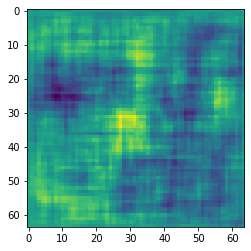

In [29]:
noise = tf.random.normal([1, 100])
generated_image = generator((noise,caption_embeddings[5].reshape(1,300)), training=False)

plt.imshow(generated_image[0, :, :, 0])

In [30]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)
discriminator = build_discriminator_func(image_shape,EMBEDDING_SIZE)

In [31]:
decision = discriminator((generated_image,caption_embeddings[5].reshape(1,300)))
print(decision)

tf.Tensor([[0.4997096]], shape=(1, 1), dtype=float32)


In [32]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_image_real_text, fake_image_real_text, real_image_fake_text):
    real_loss = cross_entropy(tf.random.uniform(real_image_real_text.shape,0.8,1.0), real_image_real_text)
    fake_loss = (cross_entropy(tf.random.uniform(fake_image_real_text.shape,0.0,0.2), fake_image_real_text) + 
                 cross_entropy(tf.random.uniform(real_image_fake_text.shape,0.0,0.2), real_image_fake_text))/2

    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [33]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2.0e-4,beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2.0e-4,beta_1 = 0.5)

In [34]:
def train_step(images,captions,fake_captions):
  seed = tf.random.normal([BATCH_SIZE, SIZE_OF_SEED],dtype=tf.float32)
 
    with tf.Gradient_Tape() as gen_tape, tf.Gradient_Tape() as disc_tape:
     generated_images = generator((seed,captions), training=True)
    real_image_real_text = discriminator((images,captions), training=True)
    real_image_fake_text = discriminator((images,fake_captions), training=True)
    fake_image_real_text = discriminator((generated_images,captions), training=True)

    gen_loss = generator_loss(fake_image_real_text)
    disc_loss = discriminator_loss(real_image_real_text, fake_image_real_text, real_image_fake_text)

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [35]:
def train(train_dataset, epochs):

seed_fixed = np.random.normal(0, 1, (ROWS_PREVIEW * COLUMNS_PREVIEW, SIZE_OF_SEED))

  fixed_embed = save_images_embeddings

  start = time.time()

  for epoch in range(epochs):
    print("epoch start...")
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for batch in train_dataset[:-1]:
      train_batch = batch['images']
      caption_batch = batch['embeddings']
      
      fake_caption_batch = np.copy(caption_batch)
      np.random.shuffle(fake_caption_batch)
      
      t = train_step(train_batch,caption_batch,fake_caption_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])
    print("now")
    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print(f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, {hms_string(epoch_elapsed)}')
    save_images(epoch,seed_fixed,fixed_embed)
    
    generator.save(os.path.join(model_path,"text_to_image_generator_cub_character.h5"))
    discriminator.save(os.path.join(model_path,"text_to_image_disc_cub_character.h5"))
    print("model saved")

  elapsed = time.time()-start
  print ('Training time:', hms_string(elapsed))

In [ ]:
train(list(train_dataset.as_numpy_iterator()), 500)

epoch start...
now
Epoch 1, gen loss=0.778418242931366,disc loss=1.5334256887435913, 0:00:54.22
1/1 [==============================] - 1s 805ms/step


model saved
epoch start...
now
Epoch 2, gen loss=0.7661057710647583,disc loss=1.4650897979736328, 0:00:53.58
1/1 [==============================] - 0s 18ms/step


model saved
epoch start...
now
Epoch 3, gen loss=0.737465500831604,disc loss=1.444717288017273, 0:00:53.54
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 4, gen loss=0.7313240766525269,disc loss=1.431799054145813, 0:00:53.62
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 5, gen loss=0.7125684022903442,disc loss=1.4274576902389526, 0:00:53.60
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 6, gen loss=0.7218473553657532,disc loss=1.421437382698059, 0:00:53.49
1/1 [==============================] - 0s 24ms/step


model saved
epoch start...
now
Epoch 7, gen loss=0.7146040201187134,disc loss=1.4119054079055786, 0:00:53.57
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 8, gen loss=0.7173663973808289,disc loss=1.4081330299377441, 0:00:53.47
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 9, gen loss=0.7233790755271912,disc loss=1.4081175327301025, 0:00:53.64
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 10, gen loss=0.7149222493171692,disc loss=1.404677152633667, 0:00:53.59
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 11, gen loss=0.7270088791847229,disc loss=1.3996572494506836, 0:00:53.52
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 12, gen loss=0.713823139667511,disc loss=1.3995904922485352, 0:00:53.53
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 13, gen loss=0.7030918598175049,disc loss=1.401484489440918, 0:00:53.40
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 14, gen loss=0.7244989275932312,disc loss=1.391432285308838, 0:00:53.33
1/1 [==============================] - 0s 18ms/step


model saved
epoch start...
now
Epoch 15, gen loss=0.7239717841148376,disc loss=1.392502784729004, 0:00:53.32
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 16, gen loss=0.7062433362007141,disc loss=1.3956811428070068, 0:00:53.45
1/1 [==============================] - 0s 18ms/step


model saved
epoch start...
now
Epoch 17, gen loss=0.7097765803337097,disc loss=1.3924332857131958, 0:00:53.71
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 18, gen loss=0.7148474454879761,disc loss=1.391905665397644, 0:00:53.64
1/1 [==============================] - 0s 18ms/step


model saved
epoch start...
now
Epoch 19, gen loss=0.7166269421577454,disc loss=1.3876436948776245, 0:00:53.45
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 20, gen loss=0.7049205303192139,disc loss=1.3910826444625854, 0:00:53.52
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 21, gen loss=0.7161060571670532,disc loss=1.3871256113052368, 0:00:53.59
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 22, gen loss=0.7162066102027893,disc loss=1.3873167037963867, 0:00:53.45
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 23, gen loss=0.749777615070343,disc loss=1.3791518211364746, 0:00:53.50
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 24, gen loss=0.7204104661941528,disc loss=1.3757903575897217, 0:00:53.35
1/1 [==============================] - 0s 18ms/step


model saved
epoch start...
now
Epoch 25, gen loss=0.7349449396133423,disc loss=1.3797292709350586, 0:00:53.63
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 26, gen loss=0.7370298504829407,disc loss=1.3743985891342163, 0:00:53.55
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 27, gen loss=0.7564380168914795,disc loss=1.368815302848816, 0:00:53.44
1/1 [==============================] - 0s 18ms/step


model saved
epoch start...
now
Epoch 28, gen loss=0.7333801984786987,disc loss=1.3828438520431519, 0:00:53.58
1/1 [==============================] - 0s 35ms/step


model saved
epoch start...
now
Epoch 29, gen loss=0.7806340456008911,disc loss=1.3590075969696045, 0:00:53.80
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 30, gen loss=0.8394091725349426,disc loss=1.3428702354431152, 0:00:53.39
1/1 [==============================] - 0s 15ms/step


model saved
epoch start...
now
Epoch 31, gen loss=0.9151887893676758,disc loss=1.317230224609375, 0:00:53.26
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 32, gen loss=1.0649499893188477,disc loss=1.2836757898330688, 0:00:53.35
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 33, gen loss=1.1055517196655273,disc loss=1.2855584621429443, 0:00:53.53
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 34, gen loss=1.1148910522460938,disc loss=1.2863519191741943, 0:00:53.32
1/1 [==============================] - 0s 15ms/step


model saved
epoch start...
now
Epoch 35, gen loss=1.069770336151123,disc loss=1.3008897304534912, 0:00:53.57
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 36, gen loss=1.1364171504974365,disc loss=1.2778820991516113, 0:00:53.70
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 37, gen loss=1.0357561111450195,disc loss=1.3108630180358887, 0:00:53.63
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 38, gen loss=1.0579665899276733,disc loss=1.313439965248108, 0:00:53.45
1/1 [==============================] - 0s 23ms/step


model saved
epoch start...
now
Epoch 39, gen loss=1.0412514209747314,disc loss=1.3072773218154907, 0:00:53.36
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 40, gen loss=1.0929276943206787,disc loss=1.2945504188537598, 0:00:53.53
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 41, gen loss=0.9216433763504028,disc loss=1.343963623046875, 0:00:53.54
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 42, gen loss=1.06026291847229,disc loss=1.2940727472305298, 0:00:53.29
1/1 [==============================] - 0s 18ms/step


model saved
epoch start...
now
Epoch 43, gen loss=0.9311007857322693,disc loss=1.3527101278305054, 0:00:53.40
1/1 [==============================] - 0s 18ms/step


model saved
epoch start...
now
Epoch 44, gen loss=0.8919642567634583,disc loss=1.3596478700637817, 0:00:53.60
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 45, gen loss=0.8844350576400757,disc loss=1.349686622619629, 0:00:53.79
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 46, gen loss=0.9485267996788025,disc loss=1.3206100463867188, 0:00:53.53
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 47, gen loss=0.9155974984169006,disc loss=1.341556429862976, 0:00:53.11
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 48, gen loss=0.8526788353919983,disc loss=1.3557417392730713, 0:00:53.29
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 49, gen loss=0.9255380630493164,disc loss=1.3232197761535645, 0:00:53.54
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 50, gen loss=0.8689718246459961,disc loss=1.349615454673767, 0:00:53.43
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 51, gen loss=0.8574463129043579,disc loss=1.3599083423614502, 0:00:53.27
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 52, gen loss=0.8874918222427368,disc loss=1.3392431735992432, 0:00:53.24
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 53, gen loss=0.8221336007118225,disc loss=1.3686796426773071, 0:00:53.39
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 54, gen loss=0.8076261281967163,disc loss=1.3654097318649292, 0:00:53.39
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 55, gen loss=0.8675830364227295,disc loss=1.3449281454086304, 0:00:53.48
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 56, gen loss=0.8436121344566345,disc loss=1.3516868352890015, 0:00:53.44
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 57, gen loss=0.8607990741729736,disc loss=1.348351240158081, 0:00:53.63
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 58, gen loss=0.8747335076332092,disc loss=1.3468271493911743, 0:00:53.34
1/1 [==============================] - 0s 15ms/step


model saved
epoch start...
now
Epoch 59, gen loss=0.899024248123169,disc loss=1.334226369857788, 0:00:53.09
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 60, gen loss=0.8736152052879333,disc loss=1.3493789434432983, 0:00:53.06
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 61, gen loss=0.9025505781173706,disc loss=1.3314824104309082, 0:00:53.62
1/1 [==============================] - 0s 15ms/step


model saved
epoch start...
now
Epoch 62, gen loss=0.9151633381843567,disc loss=1.3359876871109009, 0:00:53.26
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 63, gen loss=0.893260657787323,disc loss=1.3414939641952515, 0:00:53.37
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 64, gen loss=0.8903365731239319,disc loss=1.3389830589294434, 0:00:53.31
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 65, gen loss=0.8578478693962097,disc loss=1.3519870042800903, 0:00:53.46
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 66, gen loss=0.8727933168411255,disc loss=1.3434793949127197, 0:00:53.44
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 67, gen loss=0.855890691280365,disc loss=1.3556889295578003, 0:00:53.58
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 68, gen loss=0.8934184312820435,disc loss=1.3421859741210938, 0:00:53.53
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 69, gen loss=0.8733591437339783,disc loss=1.3443195819854736, 0:00:53.62
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 70, gen loss=0.8217664361000061,disc loss=1.3657246828079224, 0:00:53.45
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 71, gen loss=0.8812345862388611,disc loss=1.3378373384475708, 0:00:53.43
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 72, gen loss=0.8882311582565308,disc loss=1.3400466442108154, 0:00:53.37
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 73, gen loss=0.8791664242744446,disc loss=1.3447259664535522, 0:00:53.48
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 74, gen loss=0.8602309226989746,disc loss=1.3570685386657715, 0:00:53.37
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 75, gen loss=0.9068254232406616,disc loss=1.3345293998718262, 0:00:53.26
1/1 [==============================] - 0s 18ms/step


model saved
epoch start...
now
Epoch 76, gen loss=0.9304692149162292,disc loss=1.3356597423553467, 0:00:53.41
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 77, gen loss=0.8803442120552063,disc loss=1.3465759754180908, 0:00:53.42
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 78, gen loss=0.8784822821617126,disc loss=1.3421995639801025, 0:00:52.91
1/1 [==============================] - 0s 15ms/step


model saved
epoch start...
now
Epoch 79, gen loss=0.9427188038825989,disc loss=1.3273322582244873, 0:00:53.00
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 80, gen loss=0.9475061893463135,disc loss=1.3226559162139893, 0:00:53.12
1/1 [==============================] - 0s 15ms/step


model saved
epoch start...
now
Epoch 81, gen loss=1.0463109016418457,disc loss=1.3047289848327637, 0:00:53.35
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 82, gen loss=0.9723972082138062,disc loss=1.32017982006073, 0:00:53.18
1/1 [==============================] - 0s 15ms/step


model saved
epoch start...
now
Epoch 83, gen loss=0.9593190550804138,disc loss=1.323341727256775, 0:00:53.32
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 84, gen loss=0.9854813814163208,disc loss=1.3150302171707153, 0:00:53.26
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 85, gen loss=1.0334137678146362,disc loss=1.3073369264602661, 0:00:53.25
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 86, gen loss=0.987029492855072,disc loss=1.327744483947754, 0:00:53.14
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 87, gen loss=0.9185277819633484,disc loss=1.337168574333191, 0:00:53.15
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 88, gen loss=0.8320338129997253,disc loss=1.3643165826797485, 0:00:53.04
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 89, gen loss=0.8443488478660583,disc loss=1.3595820665359497, 0:00:53.28
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 90, gen loss=0.8582093119621277,disc loss=1.3492549657821655, 0:00:53.11
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 91, gen loss=0.8541958332061768,disc loss=1.3478227853775024, 0:00:53.16
1/1 [==============================] - 0s 15ms/step


model saved
epoch start...
now
Epoch 92, gen loss=0.8874985575675964,disc loss=1.3451584577560425, 0:00:53.15
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 93, gen loss=0.8414537906646729,disc loss=1.356905460357666, 0:00:53.25
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 94, gen loss=0.8286328315734863,disc loss=1.3616563081741333, 0:00:53.06
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 95, gen loss=0.8694738149642944,disc loss=1.3428406715393066, 0:00:53.00
1/1 [==============================] - 0s 18ms/step


model saved
epoch start...
now
Epoch 96, gen loss=0.8946703672409058,disc loss=1.3386507034301758, 0:00:52.99
1/1 [==============================] - 0s 23ms/step


model saved
epoch start...
now
Epoch 97, gen loss=0.9323315024375916,disc loss=1.3318606615066528, 0:00:53.27
1/1 [==============================] - 0s 18ms/step


model saved
epoch start...
now
Epoch 98, gen loss=0.9522027373313904,disc loss=1.3305366039276123, 0:00:52.99
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 99, gen loss=0.9071474075317383,disc loss=1.3396539688110352, 0:00:53.18
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 100, gen loss=0.9004341959953308,disc loss=1.3382306098937988, 0:00:53.03
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 101, gen loss=0.900980532169342,disc loss=1.3372068405151367, 0:00:53.22
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 102, gen loss=0.9654631018638611,disc loss=1.3195080757141113, 0:00:53.31
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 103, gen loss=0.9751272797584534,disc loss=1.3219332695007324, 0:00:53.09
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 104, gen loss=0.9969862699508667,disc loss=1.307950496673584, 0:00:53.19
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 105, gen loss=1.015568733215332,disc loss=1.3232791423797607, 0:00:53.24
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 106, gen loss=1.0393166542053223,disc loss=1.3007183074951172, 0:00:53.02
1/1 [==============================] - 0s 23ms/step


model saved
epoch start...
now
Epoch 107, gen loss=1.0186293125152588,disc loss=1.3113653659820557, 0:00:53.03
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 108, gen loss=0.9485588669776917,disc loss=1.3348774909973145, 0:00:53.05
1/1 [==============================] - 0s 18ms/step


model saved
epoch start...
now
Epoch 109, gen loss=0.9612122774124146,disc loss=1.3275963068008423, 0:00:53.13
1/1 [==============================] - 0s 37ms/step


model saved
epoch start...
now
Epoch 110, gen loss=0.9464394450187683,disc loss=1.3313637971878052, 0:00:53.11
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 111, gen loss=1.0106639862060547,disc loss=1.3097167015075684, 0:00:53.32
1/1 [==============================] - 0s 24ms/step


model saved
epoch start...
now
Epoch 112, gen loss=1.0067510604858398,disc loss=1.320621371269226, 0:00:53.22
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 113, gen loss=0.9928271770477295,disc loss=1.3178317546844482, 0:00:53.14
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 114, gen loss=0.9855806231498718,disc loss=1.3194133043289185, 0:00:53.38
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 115, gen loss=1.059975028038025,disc loss=1.3037395477294922, 0:00:53.19
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 116, gen loss=1.0847233533859253,disc loss=1.2996485233306885, 0:00:53.17
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 117, gen loss=1.0104485750198364,disc loss=1.3190759420394897, 0:00:53.10
1/1 [==============================] - 0s 15ms/step


model saved
epoch start...
now
Epoch 118, gen loss=0.9775364995002747,disc loss=1.3307169675827026, 0:00:53.13
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 119, gen loss=0.9829862713813782,disc loss=1.3260407447814941, 0:00:53.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 120, gen loss=0.9275683760643005,disc loss=1.3317046165466309, 0:00:52.89
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 121, gen loss=0.9834235906600952,disc loss=1.3249952793121338, 0:00:53.27
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 122, gen loss=0.9815354943275452,disc loss=1.3293620347976685, 0:00:53.18
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 123, gen loss=1.0315980911254883,disc loss=1.309999942779541, 0:00:52.97
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 124, gen loss=0.9547523856163025,disc loss=1.332888126373291, 0:00:52.93
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 125, gen loss=0.9148954153060913,disc loss=1.346917748451233, 0:00:52.99
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 126, gen loss=0.9415473937988281,disc loss=1.3240225315093994, 0:00:53.03
1/1 [==============================] - 0s 15ms/step


model saved
epoch start...
now
Epoch 127, gen loss=0.9885727167129517,disc loss=1.32233464717865, 0:00:53.15
1/1 [==============================] - 0s 15ms/step


model saved
epoch start...
now
Epoch 128, gen loss=0.9244447350502014,disc loss=1.3433713912963867, 0:00:53.12
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 129, gen loss=0.9713106155395508,disc loss=1.3272192478179932, 0:00:53.19
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 130, gen loss=1.0360242128372192,disc loss=1.305368423461914, 0:00:53.30
1/1 [==============================] - 0s 18ms/step


model saved
epoch start...
now
Epoch 131, gen loss=1.0687134265899658,disc loss=1.3004409074783325, 0:00:53.38
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 132, gen loss=1.1534249782562256,disc loss=1.29124915599823, 0:00:53.11
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 133, gen loss=1.150036334991455,disc loss=1.2822391986846924, 0:00:53.21
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 134, gen loss=1.1309301853179932,disc loss=1.2952748537063599, 0:00:53.19
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 135, gen loss=1.1492754220962524,disc loss=1.2879388332366943, 0:00:53.25
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 136, gen loss=1.0374133586883545,disc loss=1.312833547592163, 0:00:53.13
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 137, gen loss=1.0534673929214478,disc loss=1.309164047241211, 0:00:53.14
1/1 [==============================] - 0s 18ms/step


model saved
epoch start...
now
Epoch 138, gen loss=1.06233811378479,disc loss=1.308406114578247, 0:00:53.15
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 139, gen loss=1.031990885734558,disc loss=1.31183660030365, 0:00:53.47
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 140, gen loss=1.0379506349563599,disc loss=1.3147720098495483, 0:00:53.31
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 141, gen loss=1.0129388570785522,disc loss=1.3199048042297363, 0:00:53.21
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 142, gen loss=1.0061960220336914,disc loss=1.321925163269043, 0:00:53.27
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 143, gen loss=1.0265719890594482,disc loss=1.3125039339065552, 0:00:53.40
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 144, gen loss=1.0702922344207764,disc loss=1.3055024147033691, 0:00:53.39
1/1 [==============================] - 0s 15ms/step


model saved
epoch start...
now
Epoch 145, gen loss=1.0292868614196777,disc loss=1.3171536922454834, 0:00:53.29
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 146, gen loss=1.0845046043395996,disc loss=1.2993874549865723, 0:00:53.10
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 147, gen loss=1.008257508277893,disc loss=1.3206549882888794, 0:00:53.24
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 148, gen loss=1.119279146194458,disc loss=1.2951663732528687, 0:00:53.27
1/1 [==============================] - 0s 15ms/step


model saved
epoch start...
now
Epoch 149, gen loss=1.0280230045318604,disc loss=1.3170157670974731, 0:00:53.23
1/1 [==============================] - 0s 15ms/step


model saved
epoch start...
now
Epoch 150, gen loss=1.0480760335922241,disc loss=1.3064903020858765, 0:00:53.23
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 151, gen loss=1.0233181715011597,disc loss=1.3195514678955078, 0:00:53.20
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 152, gen loss=0.9739651083946228,disc loss=1.3270546197891235, 0:00:53.49
1/1 [==============================] - 0s 15ms/step


model saved
epoch start...
now
Epoch 153, gen loss=1.0094956159591675,disc loss=1.327356219291687, 0:00:53.11
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 154, gen loss=1.0025057792663574,disc loss=1.3222512006759644, 0:00:53.27
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 155, gen loss=0.9439191222190857,disc loss=1.3352079391479492, 0:00:53.21
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 156, gen loss=0.978129506111145,disc loss=1.322895884513855, 0:00:53.25
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 157, gen loss=0.9763922691345215,disc loss=1.329575777053833, 0:00:53.31
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 158, gen loss=1.000837802886963,disc loss=1.3140844106674194, 0:00:53.18
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 159, gen loss=0.9893510341644287,disc loss=1.325718641281128, 0:00:53.12
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 160, gen loss=1.000303864479065,disc loss=1.3177770376205444, 0:00:53.12
1/1 [==============================] - 0s 25ms/step


model saved
epoch start...
now
Epoch 161, gen loss=0.9534254670143127,disc loss=1.3310447931289673, 0:00:53.31
1/1 [==============================] - 0s 15ms/step


model saved
epoch start...
now
Epoch 162, gen loss=0.9246739149093628,disc loss=1.3385127782821655, 0:00:53.49
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 163, gen loss=0.9792386889457703,disc loss=1.3218265771865845, 0:00:53.26
1/1 [==============================] - 0s 15ms/step


model saved
epoch start...
now
Epoch 164, gen loss=1.0815659761428833,disc loss=1.3008753061294556, 0:00:53.20
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 165, gen loss=1.022219181060791,disc loss=1.3214430809020996, 0:00:53.26
1/1 [==============================] - 0s 15ms/step


model saved
epoch start...
now
Epoch 166, gen loss=1.0142710208892822,disc loss=1.3208317756652832, 0:00:53.32
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 167, gen loss=1.0785812139511108,disc loss=1.30316960811615, 0:00:53.44
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 168, gen loss=1.0293654203414917,disc loss=1.3105511665344238, 0:00:53.30
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 169, gen loss=1.0100884437561035,disc loss=1.313504695892334, 0:00:53.25
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 170, gen loss=0.9787960648536682,disc loss=1.3318614959716797, 0:00:53.20
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 171, gen loss=1.1033716201782227,disc loss=1.2894232273101807, 0:00:53.45
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 172, gen loss=1.0506203174591064,disc loss=1.3093465566635132, 0:00:53.36
1/1 [==============================] - 0s 15ms/step


model saved
epoch start...
now
Epoch 173, gen loss=1.0197515487670898,disc loss=1.3156455755233765, 0:00:53.37
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 174, gen loss=1.0355608463287354,disc loss=1.3168946504592896, 0:00:53.32
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 175, gen loss=1.0214070081710815,disc loss=1.3102260828018188, 0:00:53.14
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 176, gen loss=1.014180302619934,disc loss=1.318853735923767, 0:00:53.27
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 177, gen loss=1.077280044555664,disc loss=1.3018431663513184, 0:00:53.27
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 178, gen loss=1.0764799118041992,disc loss=1.3076813220977783, 0:00:53.33
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 179, gen loss=1.0514485836029053,disc loss=1.3074307441711426, 0:00:53.40
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 180, gen loss=0.9960864186286926,disc loss=1.3271392583847046, 0:00:53.40
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 181, gen loss=1.0008660554885864,disc loss=1.3168057203292847, 0:00:53.29
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 182, gen loss=1.0045830011367798,disc loss=1.3162363767623901, 0:00:53.40
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 183, gen loss=1.06215238571167,disc loss=1.3056963682174683, 0:00:53.29
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 184, gen loss=1.1297450065612793,disc loss=1.2982710599899292, 0:00:53.34
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 185, gen loss=1.0714834928512573,disc loss=1.30079185962677, 0:00:53.34
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 186, gen loss=1.1956058740615845,disc loss=1.2829234600067139, 0:00:53.64
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 187, gen loss=1.0925568342208862,disc loss=1.3015227317810059, 0:00:53.54
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 188, gen loss=1.0693988800048828,disc loss=1.3019815683364868, 0:00:53.47
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 189, gen loss=1.042664647102356,disc loss=1.3103291988372803, 0:00:53.36
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 190, gen loss=1.0509566068649292,disc loss=1.3046869039535522, 0:00:53.40
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 191, gen loss=1.145126461982727,disc loss=1.2927353382110596, 0:00:53.50
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 192, gen loss=1.1543701887130737,disc loss=1.292377233505249, 0:00:53.57
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 193, gen loss=1.1444106101989746,disc loss=1.2991396188735962, 0:00:53.52
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 194, gen loss=1.0757167339324951,disc loss=1.306746482849121, 0:00:53.33
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 195, gen loss=1.109610676765442,disc loss=1.3003745079040527, 0:00:53.38
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 196, gen loss=1.058953046798706,disc loss=1.3077143430709839, 0:00:53.40
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 197, gen loss=1.0876256227493286,disc loss=1.302323579788208, 0:00:53.56
1/1 [==============================] - 0s 18ms/step


model saved
epoch start...
now
Epoch 198, gen loss=1.074450135231018,disc loss=1.316598653793335, 0:00:53.48
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 199, gen loss=0.9996294379234314,disc loss=1.3251163959503174, 0:00:53.44
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 200, gen loss=1.0182998180389404,disc loss=1.3166624307632446, 0:00:53.39
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 201, gen loss=1.0061639547348022,disc loss=1.3230836391448975, 0:00:53.48
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 202, gen loss=1.0144317150115967,disc loss=1.3169203996658325, 0:00:53.40
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 203, gen loss=1.0117123126983643,disc loss=1.3133156299591064, 0:00:53.31
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 204, gen loss=0.9998986721038818,disc loss=1.3181647062301636, 0:00:53.42
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 205, gen loss=0.9856901168823242,disc loss=1.32634699344635, 0:00:53.33
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 206, gen loss=0.9750553965568542,disc loss=1.3215994834899902, 0:00:53.38
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 207, gen loss=1.0366575717926025,disc loss=1.3117940425872803, 0:00:53.45
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 208, gen loss=0.9955374598503113,disc loss=1.3197327852249146, 0:00:53.35
1/1 [==============================] - 0s 15ms/step


model saved
epoch start...
now
Epoch 209, gen loss=0.9850436449050903,disc loss=1.3218544721603394, 0:00:53.25
1/1 [==============================] - 0s 18ms/step


model saved
epoch start...
now
Epoch 210, gen loss=1.0226329565048218,disc loss=1.3195621967315674, 0:00:53.23
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 211, gen loss=1.0238351821899414,disc loss=1.3202568292617798, 0:00:53.37
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 212, gen loss=1.0269101858139038,disc loss=1.3110419511795044, 0:00:53.50
1/1 [==============================] - 0s 24ms/step


model saved
epoch start...
now
Epoch 213, gen loss=1.027872920036316,disc loss=1.3206431865692139, 0:00:53.68
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 214, gen loss=0.9901766777038574,disc loss=1.317782998085022, 0:00:53.30
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 215, gen loss=0.9853707551956177,disc loss=1.3230466842651367, 0:00:53.53
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 216, gen loss=0.985042929649353,disc loss=1.3237107992172241, 0:00:53.47
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 217, gen loss=0.9899957180023193,disc loss=1.3234479427337646, 0:00:53.31
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 218, gen loss=1.0507441759109497,disc loss=1.3080976009368896, 0:00:53.59
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 219, gen loss=1.0198407173156738,disc loss=1.3135117292404175, 0:00:53.23
1/1 [==============================] - 0s 15ms/step


model saved
epoch start...
now
Epoch 220, gen loss=1.0322965383529663,disc loss=1.3140407800674438, 0:00:53.24
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 221, gen loss=0.9996956586837769,disc loss=1.3233368396759033, 0:00:53.31
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 222, gen loss=1.0106061697006226,disc loss=1.3119851350784302, 0:00:53.21
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 223, gen loss=0.9477949142456055,disc loss=1.33729088306427, 0:00:53.33
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 224, gen loss=0.986639142036438,disc loss=1.3114007711410522, 0:00:53.43
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 225, gen loss=1.03922700881958,disc loss=1.3104203939437866, 0:00:53.35
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 226, gen loss=1.0193804502487183,disc loss=1.3205792903900146, 0:00:53.16
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 227, gen loss=0.9989234805107117,disc loss=1.3252485990524292, 0:00:53.16
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 228, gen loss=0.9881269931793213,disc loss=1.3209079504013062, 0:00:53.21
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 229, gen loss=1.041975975036621,disc loss=1.3017362356185913, 0:00:53.19
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 230, gen loss=1.0258368253707886,disc loss=1.3131591081619263, 0:00:53.71
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 231, gen loss=1.0976680517196655,disc loss=1.29182767868042, 0:00:53.20
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 232, gen loss=1.0611956119537354,disc loss=1.3117635250091553, 0:00:53.29
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 233, gen loss=1.0627080202102661,disc loss=1.300948143005371, 0:00:53.33
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 234, gen loss=1.082048773765564,disc loss=1.3100324869155884, 0:00:53.14
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 235, gen loss=1.0182693004608154,disc loss=1.3151535987854004, 0:00:53.23
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 236, gen loss=0.9947494268417358,disc loss=1.325592279434204, 0:00:53.33
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 237, gen loss=1.055094838142395,disc loss=1.3075813055038452, 0:00:53.19
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 238, gen loss=1.0166829824447632,disc loss=1.3148858547210693, 0:00:53.09
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 239, gen loss=1.1801906824111938,disc loss=1.2875794172286987, 0:00:53.15
1/1 [==============================] - 0s 15ms/step


model saved
epoch start...
now
Epoch 240, gen loss=1.1295783519744873,disc loss=1.29924476146698, 0:00:53.14
1/1 [==============================] - 0s 18ms/step


model saved
epoch start...
now
Epoch 241, gen loss=1.0749133825302124,disc loss=1.312241554260254, 0:00:53.15
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 242, gen loss=1.0218682289123535,disc loss=1.311238408088684, 0:00:53.32
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 243, gen loss=1.0516366958618164,disc loss=1.311257243156433, 0:00:53.29
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 244, gen loss=1.1409039497375488,disc loss=1.2837532758712769, 0:00:53.22
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 245, gen loss=1.1253951787948608,disc loss=1.2906996011734009, 0:00:53.26
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 246, gen loss=1.1133276224136353,disc loss=1.3027206659317017, 0:00:53.18
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 247, gen loss=1.0260729789733887,disc loss=1.3216240406036377, 0:00:53.15
1/1 [==============================] - 0s 15ms/step


model saved
epoch start...
now
Epoch 248, gen loss=1.0437750816345215,disc loss=1.3113499879837036, 0:00:53.27
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 249, gen loss=1.0311206579208374,disc loss=1.3057743310928345, 0:00:53.27
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 250, gen loss=1.0317617654800415,disc loss=1.3150453567504883, 0:00:53.26
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 251, gen loss=1.0267876386642456,disc loss=1.3104435205459595, 0:00:53.27
1/1 [==============================] - 0s 18ms/step


model saved
epoch start...
now
Epoch 252, gen loss=1.0311963558197021,disc loss=1.3177016973495483, 0:00:53.37
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 253, gen loss=1.0406259298324585,disc loss=1.309264063835144, 0:00:53.49
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 254, gen loss=1.0213416814804077,disc loss=1.321993112564087, 0:00:53.37
1/1 [==============================] - 0s 31ms/step


model saved
epoch start...
now
Epoch 255, gen loss=1.0495250225067139,disc loss=1.3084135055541992, 0:00:53.31
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 256, gen loss=1.0519284009933472,disc loss=1.3110016584396362, 0:00:53.24
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 257, gen loss=1.0098432302474976,disc loss=1.3156532049179077, 0:00:53.30
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 258, gen loss=1.0326155424118042,disc loss=1.314135193824768, 0:00:53.39
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 259, gen loss=1.0274173021316528,disc loss=1.3179665803909302, 0:00:53.35
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 260, gen loss=0.9983490109443665,disc loss=1.3197120428085327, 0:00:53.29
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 261, gen loss=1.0517525672912598,disc loss=1.3103549480438232, 0:00:53.35
1/1 [==============================] - 0s 18ms/step


model saved
epoch start...
now
Epoch 262, gen loss=1.0171784162521362,disc loss=1.315637230873108, 0:00:53.22
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 263, gen loss=1.044247031211853,disc loss=1.3099539279937744, 0:00:53.43
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 264, gen loss=1.0397676229476929,disc loss=1.3110188245773315, 0:00:53.38
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 265, gen loss=1.032737374305725,disc loss=1.317455530166626, 0:00:53.64
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 266, gen loss=1.0554016828536987,disc loss=1.3073922395706177, 0:00:53.23
1/1 [==============================] - 0s 17ms/step


model saved
epoch start...
now
Epoch 267, gen loss=1.0419996976852417,disc loss=1.3090659379959106, 0:00:53.15
1/1 [==============================] - 0s 18ms/step


model saved
epoch start...
now
Epoch 268, gen loss=1.0217242240905762,disc loss=1.31851327419281, 0:00:53.16
1/1 [==============================] - 0s 16ms/step


model saved
epoch start...
now
Epoch 269, gen loss=1.0229814052581787,disc loss=1.3151429891586304, 0:00:53.17
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...


In [ ]:
save_images_embeddings.shape
save_images_captions

In [ ]:
def test_image(text,num):
  test_embeddings = np.zeros((1,300),dtype=np.float32)

  x = text.lower()
  x = x.replace(" ","")
  count = 0
  for t in x:
    try:
      test_embeddings[0] += glove_embeddings[t]
      count += 1
    except:
      print(t)
      pass
  test_embeddings[0] /= count
  test_embeddings =  np.repeat(test_embeddings,[28],axis=0)
  noise = tf.random.normal([28, 100])
  save_images(num,noise,test_embeddings)

In [ ]:
test_image("The colour of the flower is purple_The petals shape is oval",1)

In [ ]:
import IPython
IPython.display.Image('/content/drive/MyDrive/Image2text/flowers/output_64_character_extended/train-1.png')

In [ ]:
test_image("The colour of the flower is yellow_The petals shape is oval",2)

In [ ]:
import IPython
IPython.display.Image('/content/drive/MyDrive/Image2text/flowers/output_64_character_extended/train-2.png')